In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Degree Centrality

As a sanity check, we first assess the extent to which GCNs can predict indegree centrality for our SBM dataset.

$$d_{degree}(n_{i}) = \sum_{j\in{}N_{i}^{1}}w_{ij}$$

For now, we only consider unweighted, undirected networks, so $w_{ij}$ takes on binary values. 

GraphConv trivially reduces to $d_{degree}$ when $\Theta_{1}^{0}\rightarrow{}0, \Theta^{0}_{2}\rightarrow{}1$ and $\Theta_{1}^{q}\rightarrow{}x, \Theta^{q}_{2}\rightarrow{}0$ for all $q\leq{}l_{max}$: 

$$ x^{1}_{i} = \Theta_{1}^{0}(x_{i}^{0}) + \sum_{j\in{}N_{i}^{1}}w_{ij}\Theta_{2}^{0}(x_{j}^{0})$$
$$ x^{1}_{i} = 0 + \sum_{j\in{}N_{i}^{1}}w_{ij} = d_{degree}(v_{i})$$
$$ x^{2}_{i} = \Theta_{1}^{1}(d_{degree}(v_{i})) + \sum_{j\in{}N_{i}^{1}}w_{ij}\Theta_{2}^{1}(d_{degree}(v_{j}))$$
$$ x^{2}_{i} = d_{degree}(v_{i}) + 0 $$
$$ ... $$

An EdgeConv model can also learn an exact solution, which occurs at $\Theta{}^{q}\rightarrow{}1$ for all $q\leq{}l_{max}$ regardless of $\vec{x^{0}}$:

$$x_{i}^{q} = \sum_{j\in{}N_{i}^{1}}w_{ij}\Theta{}^{l}(x_{i}^{q}||x_{j}^{q}-x_{i}^{q})$$
$$x_{i}^{q} = \sum_{j\in{}N_{i}^{1}}w_{ij} = d_{degree}(v_{i})$$
$$...$$

Losses/rank displacement are plotted below for $l_{max}=4$ GraphConv and EdgeConv models, which are each trained to minimze $L(\vec{x},\vec{d}_{degree})$.

In [2]:
num_graphs = 250
d = []
torch.manual_seed(0)

for _ in range(num_graphs):

    # Get Cluster sizes and connection probabilities
    n = torch.randint(50,100,(5,))
    p = 1/n + (10/n - 1/n) * torch.rand((5,5))
    p = .5 * (p + p.T)

    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Create TorchGeometric Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

In [3]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute degree centrality
    y = torch_sparse.sum(adj,dim=1)
    
    # Assign as target
    G.y = y
    d[idx] = G
    
train,test = d[:200],d[200::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=25,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=25,shuffle=True)

In [7]:
torch.manual_seed(0)

Graph = GraphConv(1,4,1,4).cuda()
Edge = EdgeConv(1,4,1,4).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,100,lr=1e-1)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,100,lr=1e-3)
torch.cuda.empty_cache()

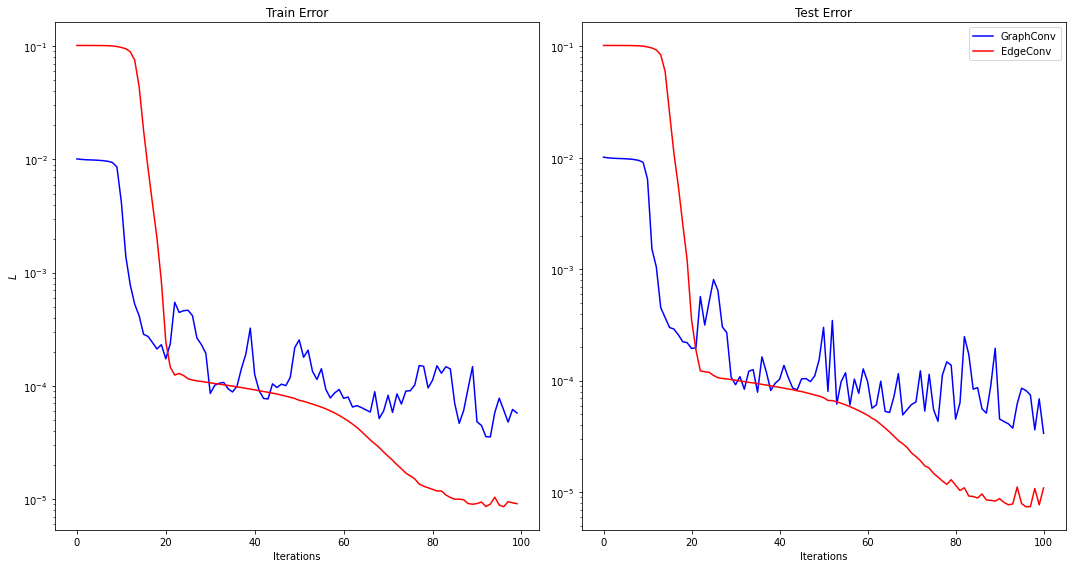

In [8]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.semilogy(graph_metrics[0],color='blue')
plt.semilogy(edge_metrics[0],color='red')
plt.title('Train Error')
plt.ylabel('$L$')
plt.xlabel('Iterations')

plt.subplot(1,2,2)
plt.semilogy(graph_metrics[1],color='blue',label='GraphConv')
plt.semilogy(edge_metrics[1],color='red',label='EdgeConv')
plt.title('Test Error')
plt.xlabel('Iterations')

plt.legend()
plt.tight_layout();

We plot a) training loss and b) test loss. GraphConv and EdgeConv hit respective final test losses of approx. $1e^{-4}$ and $1e^{-5}$. This confirms that they are functioning more or less correctly and, as degree is arguably the simplest centrality measure, provides us with a rough idea of performance for more complex tasks and centralities. 

Note: $r_{disp}$, like most ranking measures, is quite sensitive to ties, and the nature of $d_{degree}$ for unweighted networks means that there are plenty of them. For this reason, we do not show $r_{disp}$ here.